# Monte Carlo Ranom Forest + Linear Regression

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from time import time
import json
import sys

from thorr.utils import read_config

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression
from sklearn.inspection import permutation_importance

from joblib import dump, load

from permetrics.regression import RegressionMetric
from quantile_forest import RandomForestQuantileRegressor

import glob

In [2]:
config_path = Path('/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/03-HAB/.env/hab_config.ini')
config_dict = read_config(config_path)
project_dir = Path(config_dict["project"]["project_dir"])

In [3]:
results_dir = Path('/Volumes/STLP-0800/monte_carlo_rfr_base/')
dev_results_dir = results_dir / 'dev_results'
dev_results_dir.mkdir(parents=True, exist_ok=True)
dev_models_dir = results_dir / 'dev_models'
dev_models_dir.mkdir(parents=True, exist_ok=True)
test_results_dir = results_dir / 'test_results'
test_results_dir.mkdir(parents=True, exist_ok=True)
final_models_dir = results_dir / 'final_models'
final_models_dir.mkdir(parents=True, exist_ok=True)

## Analysis

In [4]:
train_results_df = pd.concat([pd.read_csv(f) for f in glob.glob(str(dev_results_dir) + '/*train*.csv')], ignore_index=True)
val_results_df = pd.concat([pd.read_csv(f) for f in glob.glob(str(dev_results_dir) + '/*val*.csv')], ignore_index=True)
test_results_df = pd.read_csv(test_results_dir / 'monte_carlo_test_results.csv', parse_dates=['Date'])
test_results_df['pred_chl_a'] = 10**test_results_df['pred_log_chl_a']


In [5]:
train_stats_group = train_results_df.groupby(['Date', 'ReachID', ])
train_stats = []
for (Date, ReachID), group in train_stats_group:
    
    perc_5_log_chl_a = group["pred_log_chl_a"].quantile(0.05)
    perc_25_log_chl_a = group["pred_log_chl_a"].quantile(0.25)
    perc_50_log_chl_a = group["pred_log_chl_a"].quantile(0.50)
    perc_75_log_chl_a = group["pred_log_chl_a"].quantile(0.75)
    perc_95_log_chl_a = group["pred_log_chl_a"].quantile(0.95)
    mean_log_chl_a = group["pred_log_chl_a"].mean()
    true_log_chl_a = group["log_chl_a"].iloc[0]
    
    perc_5_chl_a = 10**perc_5_log_chl_a
    perc_25_chl_a = 10**perc_25_log_chl_a
    perc_50_chl_a = 10**perc_50_log_chl_a
    perc_75_chl_a = 10**perc_75_log_chl_a
    perc_95_chl_a = 10**perc_95_log_chl_a
    mean_chl_a = 10**mean_log_chl_a
    true_chl_a = 10**true_log_chl_a

    predicted_chl_a = perc_50_chl_a # using median, but may use the mean instead.

    lower_error = predicted_chl_a - perc_25_chl_a
    upper_error = perc_75_chl_a - predicted_chl_a

    train_stats.append(pd.DataFrame({
        'Date': Date,
        'ReachID': ReachID,
        'true_log_chl_a': true_log_chl_a,
        'perc_5_log_chl_a': perc_5_log_chl_a,
        'perc_25_log_chl_a': perc_25_log_chl_a,
        'perc_50_log_chl_a': perc_50_log_chl_a,
        'perc_75_log_chl_a': perc_75_log_chl_a,
        'perc_95_log_chl_a': perc_95_log_chl_a,
        'mean_log_chl_a': mean_log_chl_a,
        'true_chl_a': true_chl_a,
        'perc_5_chl_a': perc_5_chl_a,
        'perc_25_chl_a': perc_25_chl_a,
        'perc_50_chl_a': perc_50_chl_a,
        'perc_75_chl_a': perc_75_chl_a,
        'perc_95_chl_a': perc_95_chl_a,
        'mean_chl_a': mean_chl_a,
        'lower_error': lower_error,
        'upper_error': upper_error,
    }, index=[0]))

train_stats_df = pd.concat(train_stats, ignore_index=True)

train_stats_df['residuals'] = train_stats_df['true_log_chl_a'] - train_stats_df['perc_50_log_chl_a']
train_residual_mean = train_stats_df['residuals'].mean()
train_residual_std = train_stats_df['residuals'].std()

del train_results_df

In [6]:
val_stats_group = val_results_df.groupby(['Date', 'ReachID', ])
val_stats = []
for (Date, ReachID), group in val_stats_group:
    
    perc_5_log_chl_a = group["pred_log_chl_a"].quantile(0.05)
    perc_25_log_chl_a = group["pred_log_chl_a"].quantile(0.25)
    perc_50_log_chl_a = group["pred_log_chl_a"].quantile(0.50)
    perc_75_log_chl_a = group["pred_log_chl_a"].quantile(0.75)
    perc_95_log_chl_a = group["pred_log_chl_a"].quantile(0.95)
    mean_log_chl_a = group["pred_log_chl_a"].mean()
    true_log_chl_a = group["log_chl_a"].iloc[0]
    
    perc_5_chl_a = 10**perc_5_log_chl_a
    perc_25_chl_a = 10**perc_25_log_chl_a
    perc_50_chl_a = 10**perc_50_log_chl_a
    perc_75_chl_a = 10**perc_75_log_chl_a
    perc_95_chl_a = 10**perc_95_log_chl_a
    mean_chl_a = 10**mean_log_chl_a
    true_chl_a = 10**true_log_chl_a

    predicted_chl_a = perc_50_chl_a # using median, but may use the mean instead.

    lower_error = predicted_chl_a - perc_25_chl_a
    upper_error = perc_75_chl_a - predicted_chl_a

    val_stats.append(pd.DataFrame({
        'Date': Date,
        'ReachID': ReachID,
        'true_log_chl_a': true_log_chl_a,
        'perc_5_log_chl_a': perc_5_log_chl_a,
        'perc_25_log_chl_a': perc_25_log_chl_a,
        'perc_50_log_chl_a': perc_50_log_chl_a,
        'perc_75_log_chl_a': perc_75_log_chl_a,
        'perc_95_log_chl_a': perc_95_log_chl_a,
        'mean_log_chl_a': mean_log_chl_a,
        'true_chl_a': true_chl_a,
        'perc_5_chl_a': perc_5_chl_a,
        'perc_25_chl_a': perc_25_chl_a,
        'perc_50_chl_a': perc_50_chl_a,
        'perc_75_chl_a': perc_75_chl_a,
        'perc_95_chl_a': perc_95_chl_a,
        'mean_chl_a': mean_chl_a,
        'lower_error': lower_error,
        'upper_error': upper_error,
    }, index=[0]))

val_stats_df = pd.concat(val_stats, ignore_index=True)

val_stats_df['residuals'] = val_stats_df['true_log_chl_a'] - val_stats_df['perc_50_log_chl_a']
val_residual_mean = val_stats_df['residuals'].mean()
val_residual_std = val_stats_df['residuals'].std()

del val_results_df

In [7]:
test_stats_group = test_results_df.groupby(['Date', 'ReachID', ])
test_stats = []
for (Date, ReachID), group in test_stats_group:
    
    perc_5_log_chl_a = group["pred_log_chl_a"].quantile(0.05)
    perc_25_log_chl_a = group["pred_log_chl_a"].quantile(0.25)
    perc_50_log_chl_a = group["pred_log_chl_a"].quantile(0.50)
    perc_75_log_chl_a = group["pred_log_chl_a"].quantile(0.75)
    perc_95_log_chl_a = group["pred_log_chl_a"].quantile(0.95)
    mean_log_chl_a = group["pred_log_chl_a"].mean()
    true_log_chl_a = group["log_chl_a"].iloc[0]
    
    perc_5_chl_a = 10**perc_5_log_chl_a
    perc_25_chl_a = 10**perc_25_log_chl_a
    perc_50_chl_a = 10**perc_50_log_chl_a
    perc_75_chl_a = 10**perc_75_log_chl_a
    perc_95_chl_a = 10**perc_95_log_chl_a
    mean_chl_a = 10**mean_log_chl_a
    true_chl_a = 10**true_log_chl_a

    predicted_chl_a = perc_50_chl_a # using median, but may use the mean instead.

    lower_error = predicted_chl_a - perc_25_chl_a
    upper_error = perc_75_chl_a - predicted_chl_a

    test_stats.append(pd.DataFrame({
        'Date': Date,
        'ReachID': ReachID,
        'true_log_chl_a': true_log_chl_a,
        'perc_5_log_chl_a': perc_5_log_chl_a,
        'perc_25_log_chl_a': perc_25_log_chl_a,
        'perc_50_log_chl_a': perc_50_log_chl_a,
        'perc_75_log_chl_a': perc_75_log_chl_a,
        'perc_95_log_chl_a': perc_95_log_chl_a,
        'mean_log_chl_a': mean_log_chl_a,
        'true_chl_a': true_chl_a,
        'perc_5_chl_a': perc_5_chl_a,
        'perc_25_chl_a': perc_25_chl_a,
        'perc_50_chl_a': perc_50_chl_a,
        'perc_75_chl_a': perc_75_chl_a,
        'perc_95_chl_a': perc_95_chl_a,
        'mean_chl_a': mean_chl_a,
        'lower_error': lower_error,
        'upper_error': upper_error,
    }, index=[0]))

test_stats_df = pd.concat(test_stats, ignore_index=True)

test_stats_df['residuals'] = test_stats_df['true_log_chl_a'] - test_stats_df['perc_50_log_chl_a']
test_residual_mean = test_stats_df['residuals'].mean()
test_residual_std = test_stats_df['residuals'].std()

del test_results_df

Within 1 Std Dev: 4547 samples
Within 2 Std Dev: 1327 samples


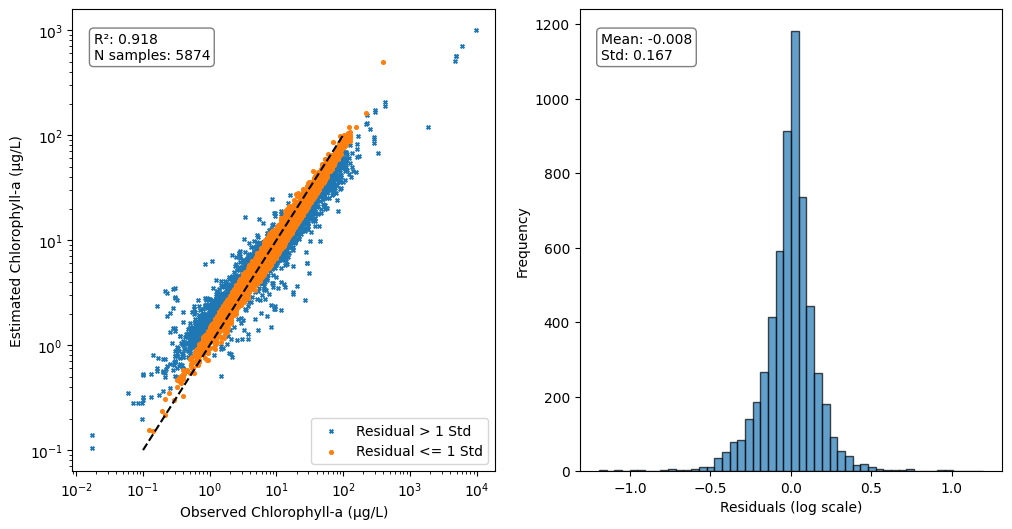

In [31]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6))


train_stats_df['residuals'] = train_stats_df['true_log_chl_a'] - train_stats_df['perc_50_log_chl_a']

train_residuals = train_stats_df['residuals']
train_residual_mean = train_residuals.mean()
train_residual_std = train_residuals.std()

train_1_std = train_stats_df[(train_stats_df['residuals'] >= (train_residual_mean - train_residual_std)) & (train_stats_df['residuals'] <= (train_residual_mean + train_residual_std))]
train_2_std = train_stats_df[(train_stats_df['residuals'] < (train_residual_mean - train_residual_std)) | (train_stats_df['residuals'] > (train_residual_mean + train_residual_std))]
print(f"Within 1 Std Dev: {len(train_1_std)} samples")
print(f"Within 2 Std Dev: {len(train_2_std)} samples")
ax.scatter(train_2_std['true_chl_a'], train_2_std['perc_50_chl_a'], alpha=1, label='Residual > 1 Std', s=7, marker='x')
ax.scatter(train_1_std['true_chl_a'], train_1_std['perc_50_chl_a'], alpha=1, label='Residual <= 1 Std', s=7)

r2 = r2_score(train_stats_df['true_log_chl_a'], train_stats_df['perc_50_log_chl_a'])

ax.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(train_stats_df)}', 
         transform=ax.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax.set_ylabel('Estimated Chlorophyll-a (µg/L)')

# Plot histogram of residuals

# annotate mean and std on the plot
ax1.text(0.05, 0.95, f'Mean: {train_residual_mean:.3f}\nStd: {train_residual_std:.3f}',
            transform=ax1.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax1.hist(train_residuals, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Residuals (log scale)')
ax1.set_ylabel('Frequency')
ax.legend()

In [32]:
train_1_std.to_csv('train_1_std.csv', index=False)
train_2_std.to_csv('train_2_std.csv', index=False)

Within 1 Std Dev: 4498 samples
Within 2 Std Dev: 1376 samples


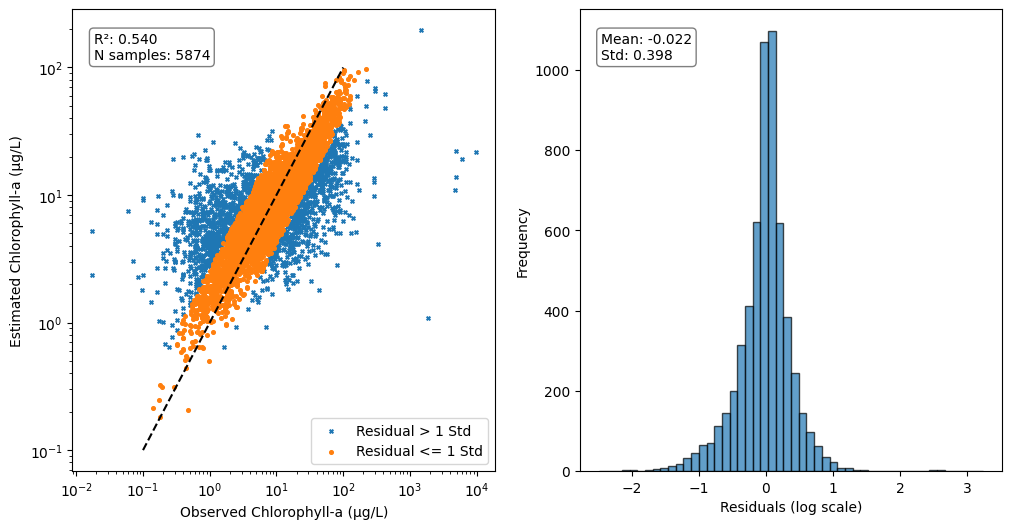

In [33]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6))


val_stats_df['residuals'] = val_stats_df['true_log_chl_a'] - val_stats_df['perc_50_log_chl_a']

val_residuals = val_stats_df['residuals']
val_residual_mean = val_residuals.mean()
val_residual_std = val_residuals.std()

val_1_std = val_stats_df[(val_stats_df['residuals'] >= (val_residual_mean - val_residual_std)) & (val_stats_df['residuals'] <= (val_residual_mean + val_residual_std))]
val_2_std = val_stats_df[(val_stats_df['residuals'] < (val_residual_mean - val_residual_std)) | (val_stats_df['residuals'] > (val_residual_mean + val_residual_std))]
print(f"Within 1 Std Dev: {len(val_1_std)} samples")
print(f"Within 2 Std Dev: {len(val_2_std)} samples")
ax.scatter(val_2_std['true_chl_a'], val_2_std['perc_50_chl_a'], alpha=1, label='Residual > 1 Std', s=7, marker='x')
ax.scatter(val_1_std['true_chl_a'], val_1_std['perc_50_chl_a'], alpha=1, label='Residual <= 1 Std', s=7)

r2 = r2_score(val_stats_df['true_log_chl_a'], val_stats_df['perc_50_log_chl_a'])

ax.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(val_stats_df)}', 
         transform=ax.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax.set_ylabel('Estimated Chlorophyll-a (µg/L)')

# Plot histogram of residuals

# annotate mean and std on the plot
ax1.text(0.05, 0.95, f'Mean: {val_residual_mean:.3f}\nStd: {val_residual_std:.3f}',
            transform=ax1.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax1.hist(val_residuals, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Residuals (log scale)')
ax1.set_ylabel('Frequency')
ax.legend()

Within 1 Std Dev: 1674 samples
Within 2 Std Dev: 497 samples


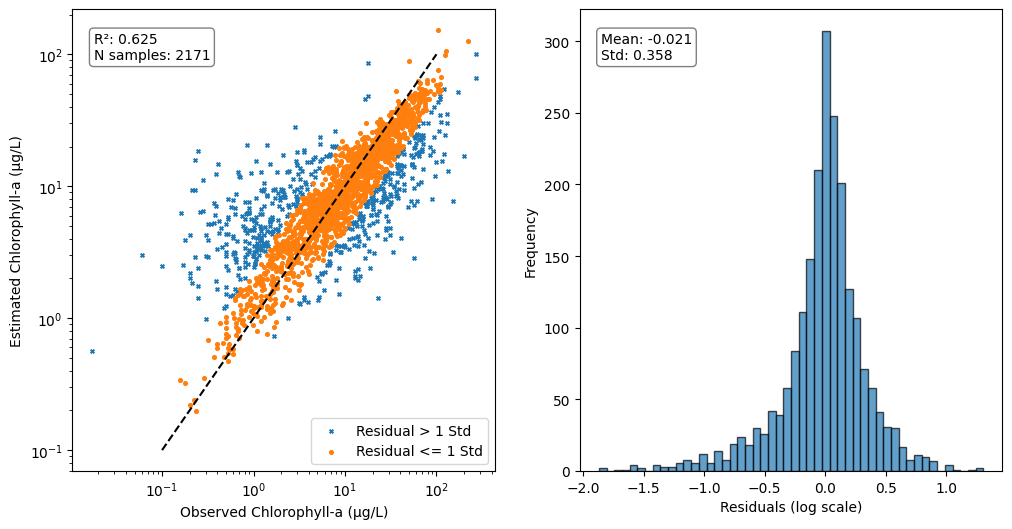

In [34]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6))


test_stats_df['residuals'] = test_stats_df['true_log_chl_a'] - test_stats_df['perc_50_log_chl_a']

test_residuals = test_stats_df['residuals']
test_residual_mean = test_residuals.mean()
test_residual_std = test_residuals.std()

test_1_std = test_stats_df[(test_stats_df['residuals'] >= (test_residual_mean - test_residual_std)) & (test_stats_df['residuals'] <= (test_residual_mean + test_residual_std))]
test_2_std = test_stats_df[(test_stats_df['residuals'] < (test_residual_mean - test_residual_std)) | (test_stats_df['residuals'] > (test_residual_mean + test_residual_std))]
print(f"Within 1 Std Dev: {len(test_1_std)} samples")
print(f"Within 2 Std Dev: {len(test_2_std)} samples")
ax.scatter(test_2_std['true_chl_a'], test_2_std['perc_50_chl_a'], alpha=1, label='Residual > 1 Std', s=7, marker='x')
ax.scatter(test_1_std['true_chl_a'], test_1_std['perc_50_chl_a'], alpha=1, label='Residual <= 1 Std', s=7)

r2 = r2_score(test_stats_df['true_log_chl_a'], test_stats_df['perc_50_log_chl_a'])

ax.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(test_stats_df)}', 
         transform=ax.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax.set_ylabel('Estimated Chlorophyll-a (µg/L)')

# Plot histogram of residuals

# annotate mean and std on the plot
ax1.text(0.05, 0.95, f'Mean: {test_residual_mean:.3f}\nStd: {test_residual_std:.3f}',
            transform=ax1.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax1.hist(test_residuals, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Residuals (log scale)')
ax1.set_ylabel('Frequency')
ax.legend()

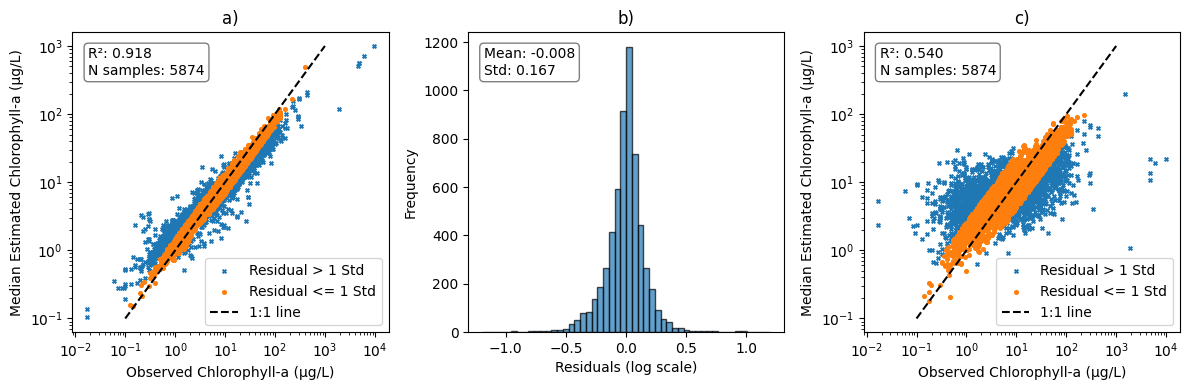

In [51]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))
ax.scatter(train_2_std['true_chl_a'], train_2_std['perc_50_chl_a'], alpha=1, label='Residual > 1 Std', s=7, marker='x')
ax.scatter(train_1_std['true_chl_a'], train_1_std['perc_50_chl_a'], alpha=1, label='Residual <= 1 Std', s=7)

r2 = r2_score(train_stats_df['true_log_chl_a'], train_stats_df['perc_50_log_chl_a'])

ax.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(train_stats_df)}', 
         transform=ax.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([0.1, 1000], [0.1, 1000], 'k--', label='1:1 line')  # 1:1 line
ax.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax.set_ylabel('Median Estimated Chlorophyll-a (µg/L)')

# Plot histogram of residuals

# annotate mean and std on the plot
ax1.text(0.05, 0.95, f'Mean: {train_residual_mean:.3f}\nStd: {train_residual_std:.3f}',
            transform=ax1.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax1.hist(train_residuals, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Residuals (log scale)')
ax1.set_ylabel('Frequency')
ax.legend()


ax2.scatter(val_2_std['true_chl_a'], val_2_std['perc_50_chl_a'], alpha=1, label='Residual > 1 Std', s=7, marker='x')
ax2.scatter(val_1_std['true_chl_a'], val_1_std['perc_50_chl_a'], alpha=1, label='Residual <= 1 Std', s=7)

r2_val = r2_score(val_stats_df['true_log_chl_a'], val_stats_df['perc_50_log_chl_a'])

ax2.text(0.05, 0.95, f'R²: {r2_val:.3f}\nN samples: {len(val_stats_df)}', 
         transform=ax2.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot([0.1, 1000], [0.1, 1000], 'k--', label='1:1 line')  # 1:1 line
ax2.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax2.set_ylabel('Median Estimated Chlorophyll-a (µg/L)')
ax2.legend()

ax.set_title('a)')
ax2.set_title('c)')
ax1.set_title('b)')

fig.tight_layout()
fig.savefig('residual_analysis.png', dpi=300)